## Class Definition for CNN

In [4]:
from scipy.ndimage import zoom
from scipy.signal import butter, filtfilt

import math, random
import torch
import torchaudio
from torchaudio import transforms
import numpy as np
import matplotlib.pyplot as plt
import numpy as np 
import csv

class DataUtils():
    #---------------------------------------------
    #Load a file and returns it as a list
    #---------------------------------------------
    @staticmethod
    def x_loading(subsetXTrainFiles, myDir):
        #Takes a list of files and returns a numpy array of shape (nObservations, nChannels, nSamples)
        X_subset=[]
        
        for file in subsetXTrainFiles:    
            myArray=np.load(os.path.join(myDir, file))
            X_subset.append(myArray)
        X_subset=np.array(X_subset) #X_subset.shape (1989 observations, 4 channels :sound, accel X,Y,Z, 250062 samples per observation)
        
        return X_subset
    
    @staticmethod
    def saveFile(myNpy, destDir, fileName):
        """Save a file."""
        np.save(os.path.join(destDir, fileName), myNpy)

    #---------------------------------------------
    #Align the data to have a fixed duration.
    #---------------------------------------------
    @staticmethod
    def padTruncate(mySig, maxTime, fs):
        """Pad or truncate the data to have a fixed duration.
        Args:
            mySig: the signal as a list
            maxTime: The maximum time in milliseconds.
            fs: the sampling rate in Hz    
            """
        sLen = mySig.shape[0]
        trunc=0
        maxLen=int(maxTime*int(fs/1000))
        if sLen > maxLen:
            trunc=1
            mySig = mySig[:, :maxLen]
        elif sLen < maxLen:
            trunc=-1
            mySig = np.pad(mySig, ((0, maxLen - sLen),(0,0)), mode='wrap')
        
        return (trunc, len(mySig), mySig)
    
    def addGaussianNoise(mySig, std=0.02):
        """Add a gaussian noise."""
        mySig_float=mySig.astype(np.float32)
        noise = np.random.normal(0, std*np.std(np.abs(mySig_float), axis=0), mySig.shape)
        noisySig=np.clip(mySig_float+noise, -32768,32767)        
        return noisySig.astype(np.int16)
    
    def timeShift(mySig, shift_lim=0.5):
        """Shifts the data in time (reintroduce ending values at the beginning."""
        _, sLen = mySig.shape
        shiftAmt = int(np.random.random() * shift_lim * sLen)
        return np.roll(mySig, shiftAmt, axis=0)
    
    @staticmethod
    def augment_fft(data, factor=1.2):
        """Augmente ou diminue certaines fréquences du signal"""
        
        fft_data = np.fft.fft(data, axis=0)
        fft_data = fft_data * factor  # Modification du spectre
        newData=np.real(np.fft.ifft(fft_data, axis=0))  # Retourne le signal temporel
        newData = np.clip(newData, -32768, 32767)
        return newData.astype(np.int16)


    # ----------------------------
    # Generate a "classic" Spectrogram
    # ----------------------------
    @staticmethod
    def spectro_gram(mySig, n_fft=1024, hop_len=None, fs=50000):
        if hop_len is None:
            hop_len = n_fft // 4
            
        mySig=mySig.astype(np.float32)
        mySigTensor=torch.from_numpy(mySig.T)
        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.Spectrogram(n_fft=n_fft, hop_length=hop_len, power=2)(mySigTensor)
        # Convert to decibels
        spec = transforms.AmplitudeToDB()(spec)
        spec = spec.unsqueeze(0) if spec.dim() == 2 else spec
        return (spec, hop_len)
    
    # ----------------------------
    # Visualize a Spectrogram
    # ----------------------------
    @staticmethod
    def show_spectrogram(spec, fs=50000, hop=256, title="Spectrogram", ylabel='Mel Frequency Bands', channels=['Sound', 'AccX', 'AccY', 'AccZ'], mel=True):
        nbChannels=spec.shape[0]
        fig, axs = plt.subplots(nbChannels, 1, figsize=(18, 12))
        if nbChannels==1:
            axs=[axs]
        timeAxis=np.arange(0, spec.shape[2]*hop, hop)/fs
        freqAxis = np.linspace(0, fs / 2, spec.shape[1])
        for i in range(nbChannels):
            if mel:
                img=axs[i].imshow(spec[i].detach().numpy(), aspect='auto', origin='lower', cmap='viridis', extent=[timeAxis[0], timeAxis[-1], 0, spec[i].shape[0]])
            else:
                img=axs[i].imshow(spec[i].detach().numpy(), aspect='auto', origin='lower', cmap='viridis', extent=[timeAxis[0], timeAxis[-1], freqAxis[0], freqAxis[-1]])
                
            axs[i].set_title(f"Channel {channels[i]}")
            axs[i].set_ylabel(ylabel)
        plt.xlabel('Time [s]')
        plt.suptitle(title)
        plt.colorbar(img, ax=axs, orientation='vertical')
        plt.show()
        
    # ----------------------------
    # Augment a Spectrogram
    # ----------------------------
    @staticmethod
    def spectro_Augment(spectro, maxMaskPercentage=0.1,nFreqMask=1, nTimeMasks=1):
        """Augmente ou diminue certaines fréquences du signal"""
        nChannel, nFreq, nSteps = spectro.shape
        mask_value=spectro.mean()
        aug_spec=spectro.clone()
        freqMaskParam=maxMaskPercentage*nFreq
        timeMaskParam=maxMaskPercentage*nSteps
        
        for ch in range(nChannel):
            channelSpec=aug_spec[ch]
            for _ in range(nFreqMask):
                channelSpec=transforms.FrequencyMasking(freqMaskParam)(channelSpec, mask_value)

            for _ in range(nTimeMasks):
                channelSpec=transforms.TimeMasking(timeMaskParam)(channelSpec, mask_value)
            aug_spec[ch]=channelSpec
            
        return aug_spec
        


In [5]:
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np 
#Creation of a custom Dataset for PyTorch

#df must contain Label and filepath only for one fold of training data. Folds will be dealt with externally to the DataLoader class.

#Datapath is the path to the folder containing all the folds (i.e. F:\Data_BachelorHES\DataSet_CNC\DataSetsFolds) 

class DataDS(Dataset):
    
    def __init__(self, df, datapath):
        self.df=df
        self.datapath=str(datapath)
        self.duration=5001.24
        self.fs=50000
        self.channel=4
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row=self.df.iloc[idx]
        dirFile=os.path.join(self.datapath,row['FilePath'])
        observationLoad=np.load(dirFile)
        labelId=row['LabelIDs']
        _, lenObs, obs=DataUtils.padTruncate(observationLoad, self.duration, self.fs)
        spec, _ = DataUtils.spectro_gram(observationLoad, n_fft=1024, hop_len=None, fs=self.fs)
        augspec=DataUtils.spectro_Augment(spec, maxMaskPercentage=0.1,nFreqMask=2, nTimeMasks=2)
        return (spec, augspec, labelId)

# Test of Dataloader and spectogram augment

In [1]:
import pandas as pd
myNpy="F:/Data_BachelorHES/5.Dataset_preparation/3.TrainsetBalancing/GlobalFoldsFiles_Train_Test_Augmented_Cleaned.csv"
myGlobalDs=pd.read_csv(myNpy)
myGlobalDs.drop(myGlobalDs.columns[myGlobalDs.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [2]:
#myTrain contains the data to be fed to the DataDS class for batch processing later on
myTrain=myGlobalDs[(myGlobalDs['Fold']==0) & (myGlobalDs['Type']=='Train')].copy()
myTrain=myTrain.drop(columns=['Fold', 'Type', 'nb', 'condLabel'])


In [6]:
myDir="F:/Data_BachelorHES/5.Dataset_preparation/3.TrainsetBalancing"
myDs=DataDS(myTrain, myDir)


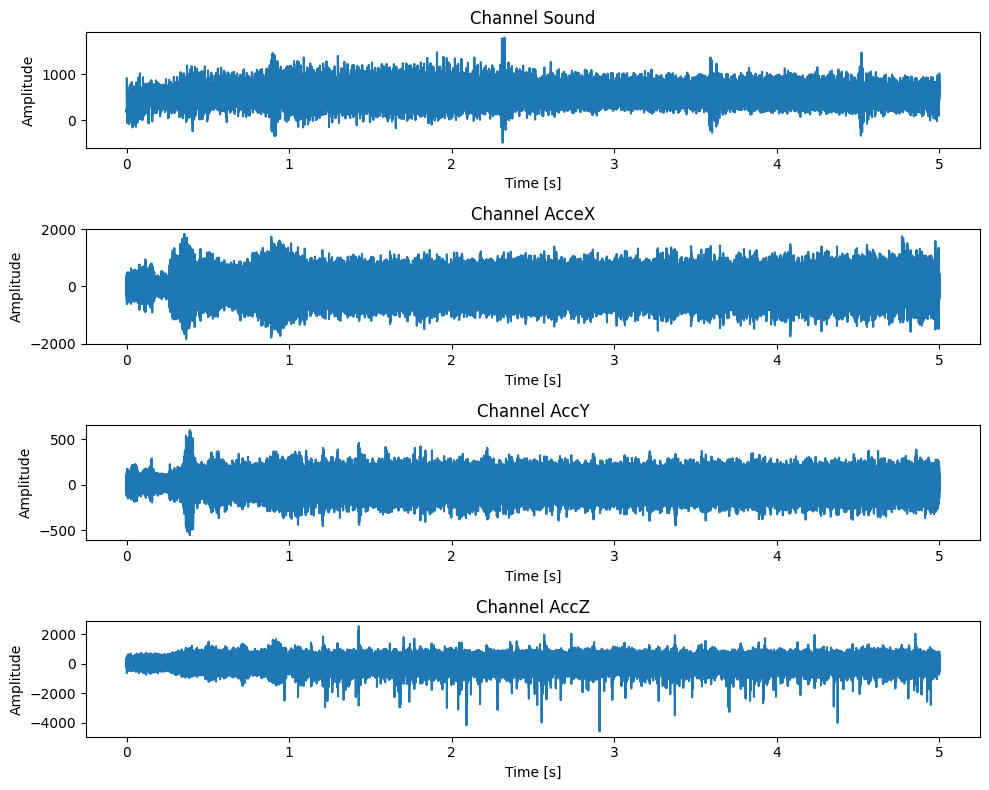

In [7]:
import matplotlib.pyplot as plt
row=myTrain.iloc[0]
dirFile=os.path.join(myDir,row['FilePath'])
observationLoad=np.load(dirFile)

# Création de la figure et des 4 sous-graphes (4 lignes, 1 colonne)
fig, axs = plt.subplots(4, 1, figsize=(10, 8))
cols=["Sound", "AcceX", "AccY", "AccZ"]
t = np.arange(len(observationLoad)) / 50000
# Boucle sur chaque colonne pour tracer les données correspondantes
for i in range(4):
    axs[i].plot(t, observationLoad[:, i])
    axs[i].set_title(f'Channel {cols[i]}')  # titre pour chaque sous-graphe
    axs[i].set_xlabel("Time [s]")
    axs[i].set_ylabel("Amplitude")

# Ajustement de l'espacement entre les sous-graphes
plt.tight_layout()
plt.show()



Label observed is :  0


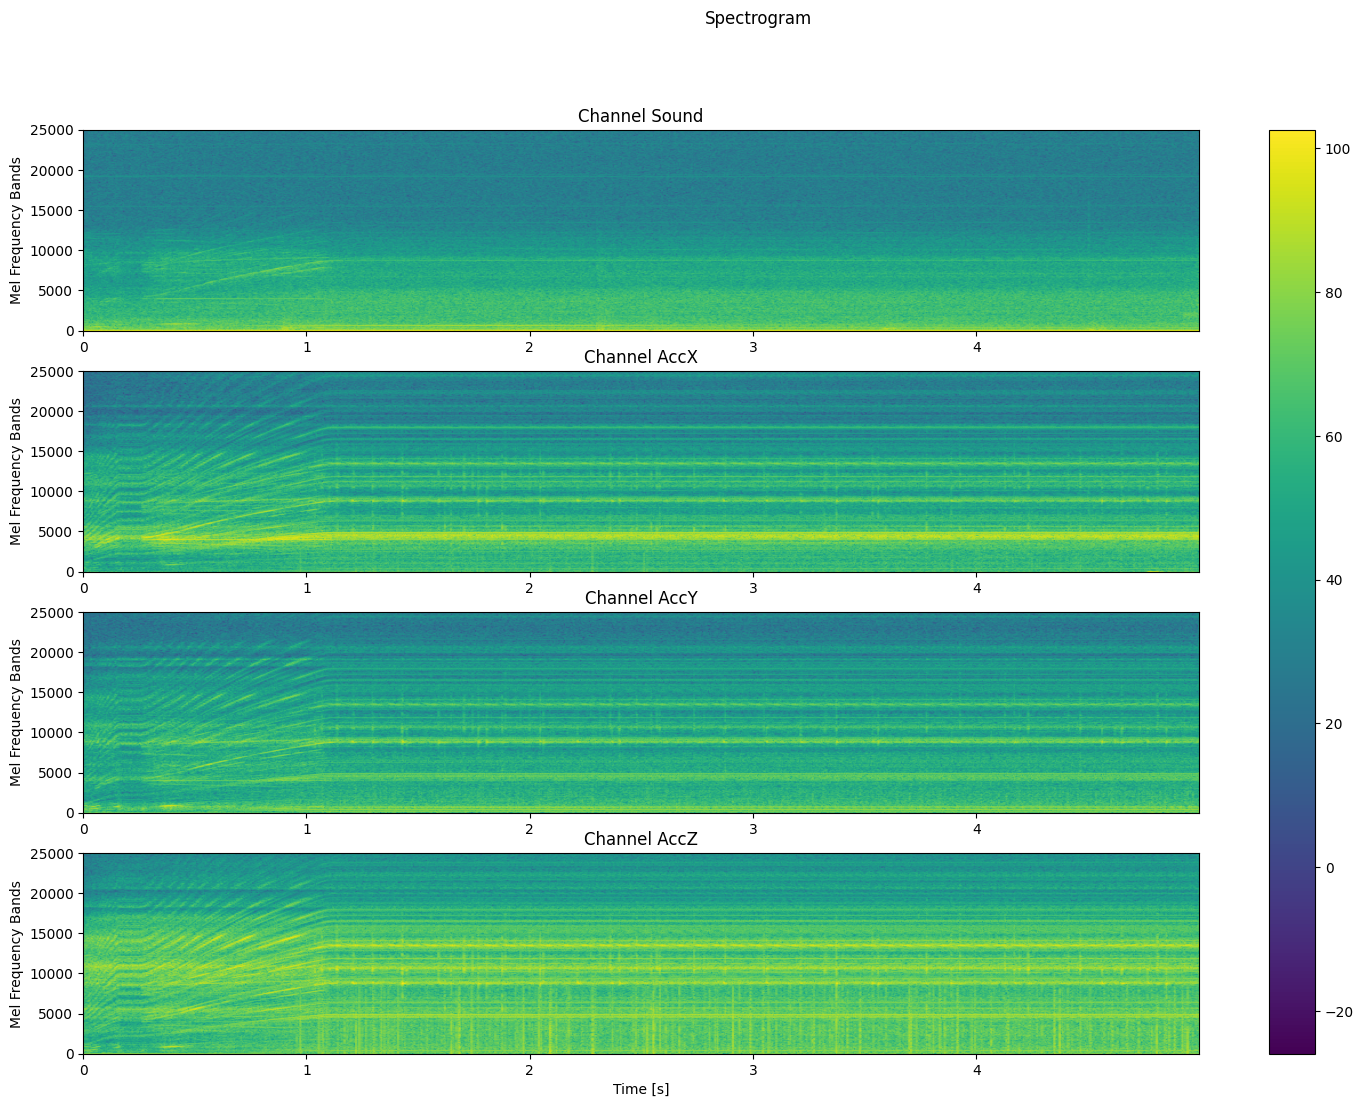

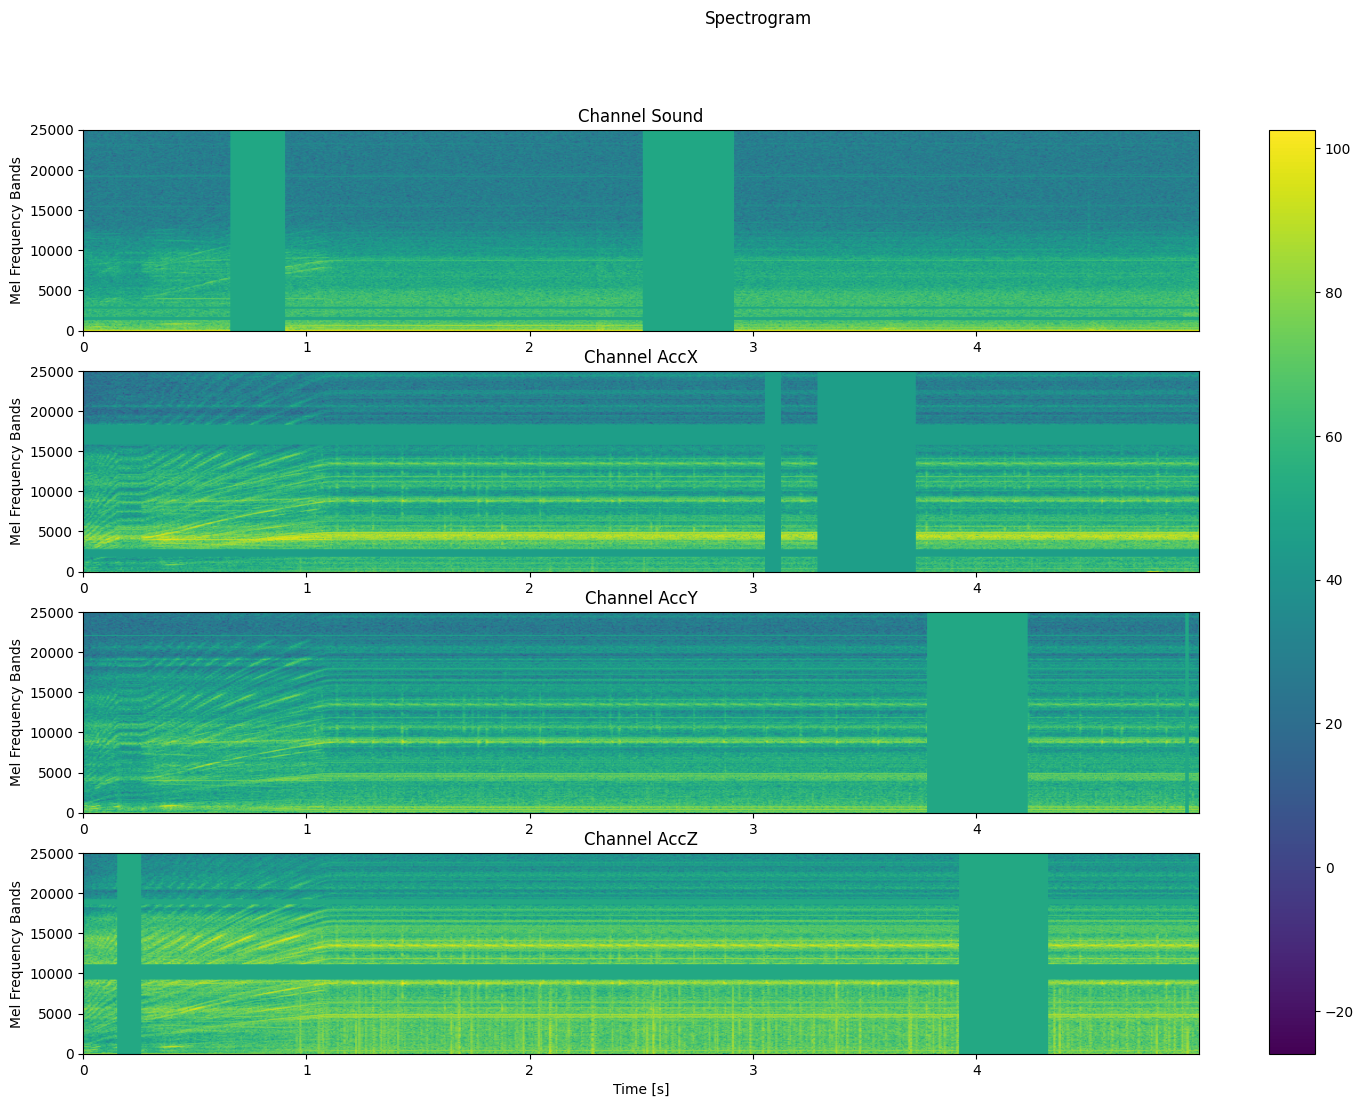

In [8]:
spec, augSpec, label=myDs.__getitem__(0)
print("Label observed is : ", label)
DataUtils.show_spectrogram(spec, fs=50000, hop=256, title="Spectrogram", ylabel='Mel Frequency Bands', channels=['Sound', 'AccX', 'AccY', 'AccZ'], mel=False)
DataUtils.show_spectrogram(augSpec, fs=50000, hop=256, title="Spectrogram", ylabel='Mel Frequency Bands', channels=['Sound', 'AccX', 'AccY', 'AccZ'], mel=False)


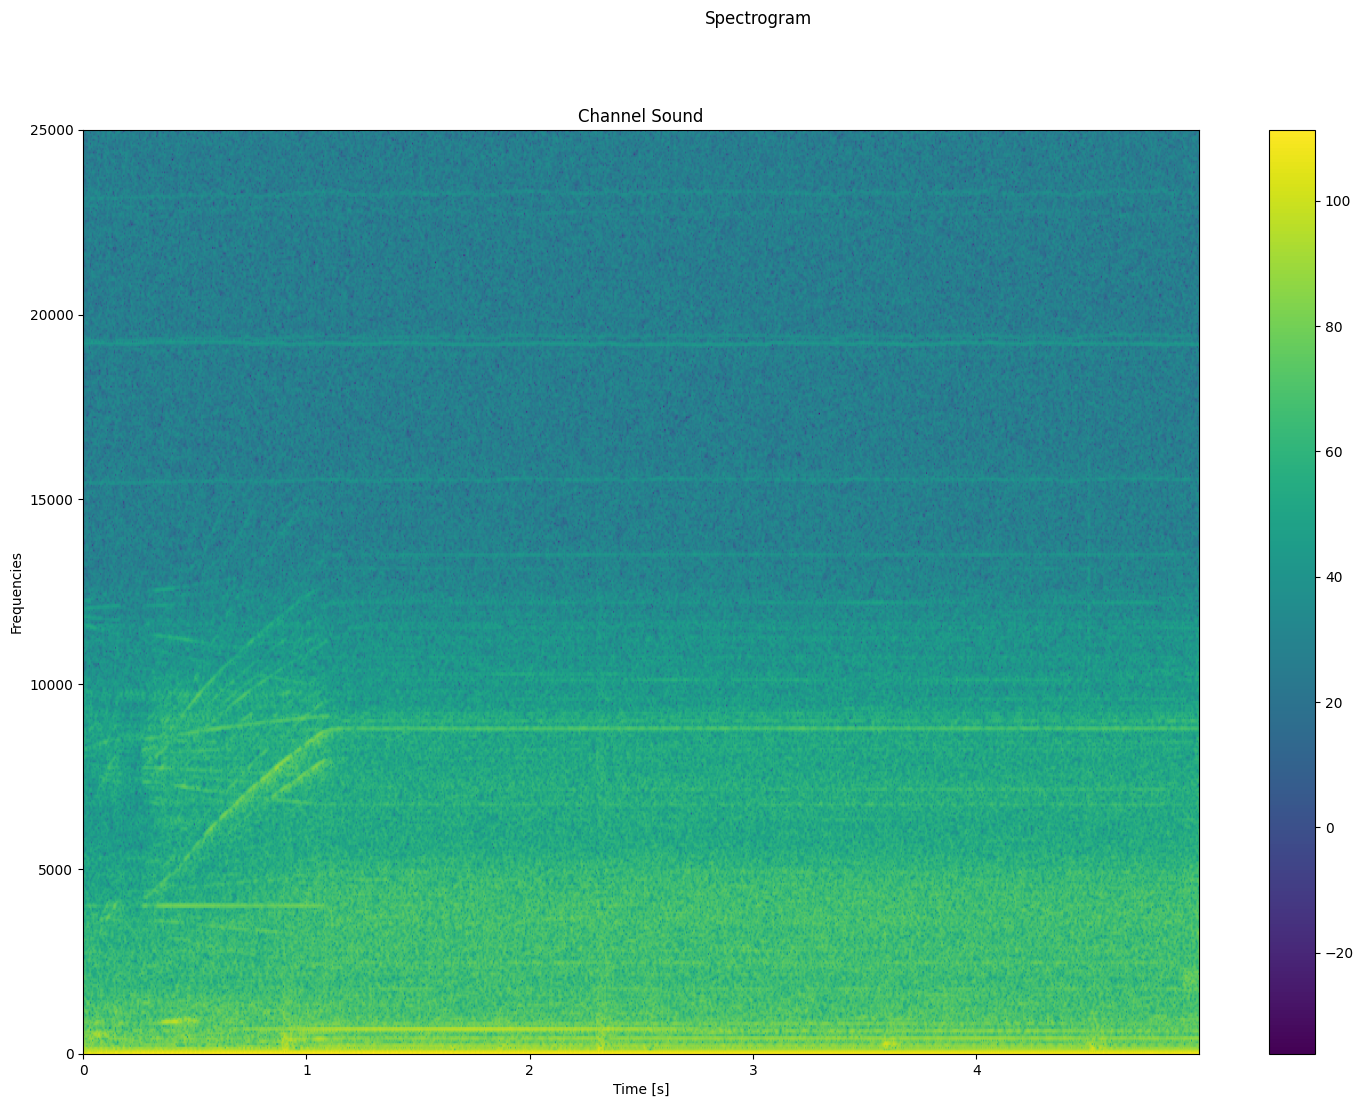

In [12]:
DataUtils.show_spectrogram(spec[0:1], fs=50000, hop=256, title="Spectrogram", ylabel='Frequencies', channels=['Sound'], mel=False)

In [11]:
spec[0:1].shape

torch.Size([1, 513, 977])

In [13]:
print("       Spectrogram   |  Shape", " (nbChannel, nbFreq, nbTime)|", " DataType " )
print("Initial Spec shape   |       ", spec.shape,"  | ",  spec.type())
print("Augmented Spec shape |       ", augSpec.shape,"  | ", augSpec.type())


       Spectrogram   |  Shape  (nbChannel, nbFreq, nbTime)|  DataType 
Initial Spec shape   |        torch.Size([4, 513, 977])   |  torch.FloatTensor
Augmented Spec shape |        torch.Size([4, 513, 977])   |  torch.FloatTensor


In [14]:
del label, spec, augSpec, myDs

## Preparation of complete Pipeline for CNN

In [22]:
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np 
#Creation of a custom Dataset for PyTorch

#df must contain Label and filepath only for one fold of training data. Folds will be dealt with externally to the DataLoader class.

#Datapath is the path to the folder containing all the folds (i.e. F:\Data_BachelorHES\DataSet_CNC\DataSetsFolds) 

class DataDS(Dataset):
    
    def __init__(self, df, datapath):
        self.df=df
        self.datapath=str(datapath)
        self.duration=5001.24
        self.fs=50000
        self.channel=4
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row=self.df.iloc[idx]
        dirFile=os.path.join(self.datapath,row['FilePath'])
        observationLoad=np.load(dirFile, mmap_mode='r')
        labelId=row['LabelIDs']
        _, lenObs, obs=DataUtils.padTruncate(observationLoad, self.duration, self.fs)
        spec, _ = DataUtils.spectro_gram(obs, n_fft=1024, hop_len=None, fs=self.fs)
        augspec=DataUtils.spectro_Augment(spec, maxMaskPercentage=0.1,nFreqMask=2, nTimeMasks=2)
        return (augspec, labelId)

In [18]:
#myTrain contains the data to be fed to the DataDS class for batch processing later on
myTrain=myGlobalDs[(myGlobalDs['Fold']==0) & (myGlobalDs['Type']=='Train')].copy()
myTrain=myTrain.drop(columns=['Fold', 'Type', 'nb', 'condLabel'])
myTest=myGlobalDs[(myGlobalDs['Fold']==0) & (myGlobalDs['Type']=='Test')].copy()
myTest=myTest.drop(columns=['Fold', 'Type', 'nb', 'condLabel'])

In [23]:
#myTrain contains the data to be fed to the DataDS class for batch processing later on
training_data=DataDS(myTrain, myDir)

train_dataloader = DataLoader(training_data, batch_size=8, shuffle=True)


In [24]:
for i, data in enumerate(train_dataloader):
    # Get the input features and target labels, and put them on the GPU
    inputs, labels = data[0], data[1]
    print(inputs.shape, labels.shape)






dlOne="train_Npy_fold_0/0712_label_T05 M06 (MECHE MD D5.8)_aug38.npy"

torch.Size([8, 4, 513, 977]) torch.Size([8])
torch.Size([8, 4, 513, 977]) torch.Size([8])
torch.Size([8, 4, 513, 977]) torch.Size([8])
torch.Size([8, 4, 513, 977]) torch.Size([8])


RuntimeError: stack expects each tensor to be equal size, but got [4, 513, 33] at entry 0 and [4, 513, 977] at entry 1

In [ ]:
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init
#       Spectrogram   |  Shape  (nbChannel, nbFreq, nbTime)|  DataType 
#Augmented Spec shape |        torch.Size([4, 513, 977])   |  torch.FloatTensor

# ----------------------------
# Audio Classification Model
# ----------------------------
class ToolClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        #This convolution block 
        inChannels=4
        outChannels=16
        self.conv1 = nn.Conv2d(inChannels, outChannels, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(outChannels)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        inChannels=16
        outChannels=32
        self.conv2 = nn.Conv2d(inChannels, outChannels, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(outChannels)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        inChannels=32
        outChannels=64
        self.conv3 = nn.Conv2d(inChannels, outChannels, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(outChannels)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        inChannels=64
        outChannels=128
        self.conv4 = nn.Conv2d(inChannels, outChannels, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(outChannels)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=outChannels, out_features=11)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = ToolClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

In [ ]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')
  
num_epochs=2   # Just for demo, adjust this higher.
training(myModel, train_dl, num_epochs)

In [ ]:

# ----------------------------
# Inference
# ----------------------------
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')
  
  # Run inference on trained model with the validation set
inference(myModel, val_dl)